# Jigsaw Toxic Comment Classification

![](toxiccomment.png)

In [1]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
 # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


In [2]:
import pandas as pd

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")
test_labels = pd.read_csv("test_labels.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)
train.head()


Train shape: (159571, 8)
Test shape: (153164, 2)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
# let's count each category
label_cols = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
category_counts = train[label_cols].sum().sort_values(ascending=False)
print(category_counts)


toxic            15294
obscene           8449
insult            7877
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64


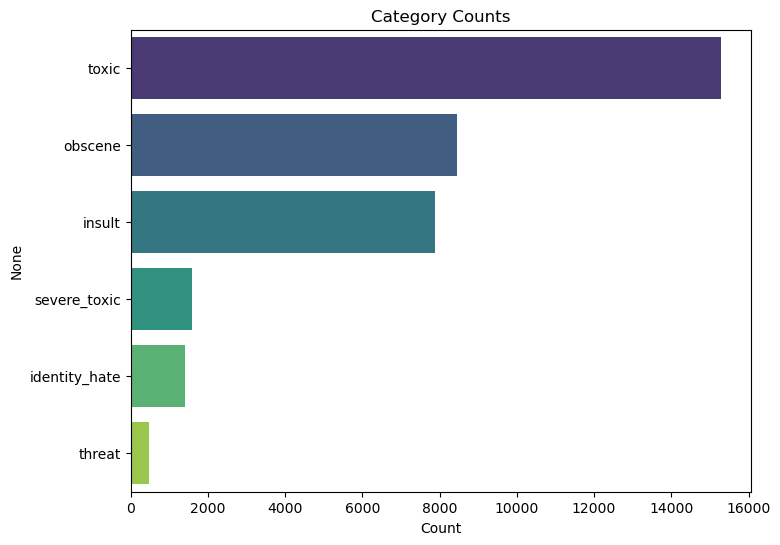

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

plt.figure(figsize=(8,6))
sns.barplot(x=category_counts.values, y=category_counts.index, palette='viridis')
plt.title('Category Counts')
plt.xlabel('Count')
plt.show()


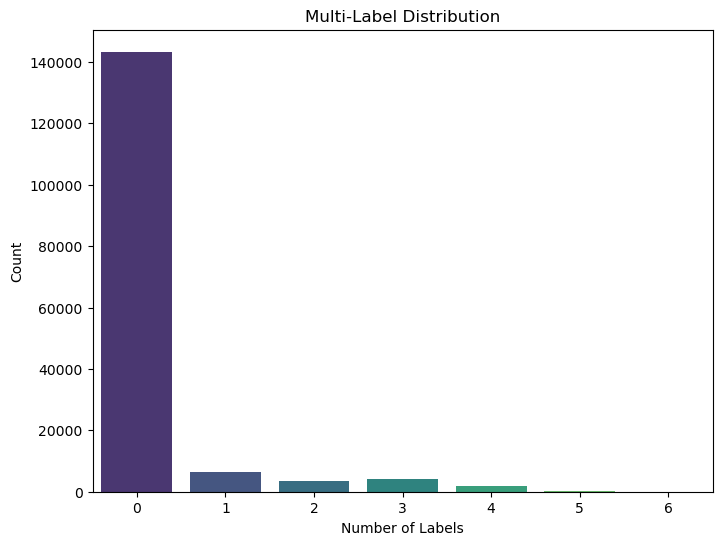

In [5]:
train['num_labels'] = train[label_cols].sum(axis=1)
multi_label_counts = train['num_labels'].value_counts().sort_index()

plt.figure(figsize=(8,6))
sns.barplot(x=multi_label_counts.index, y=multi_label_counts.values, palette='viridis')
plt.title('Multi-Label Distribution')
plt.xlabel('Number of Labels')
plt.ylabel('Count')
plt.show()


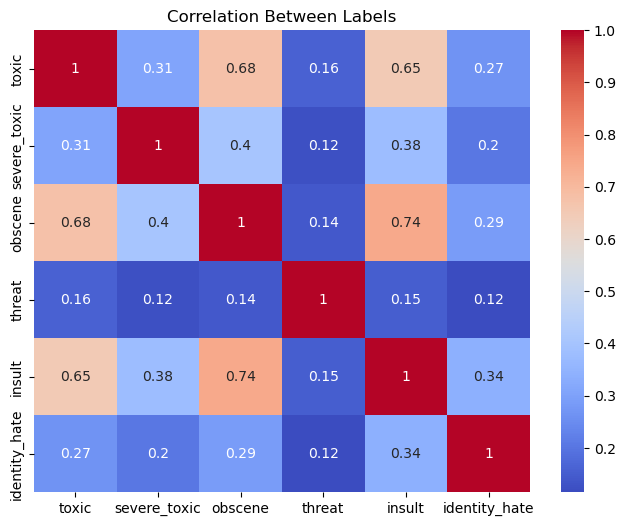

In [6]:
corr_matrix = train[label_cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Between Labels')
plt.show()


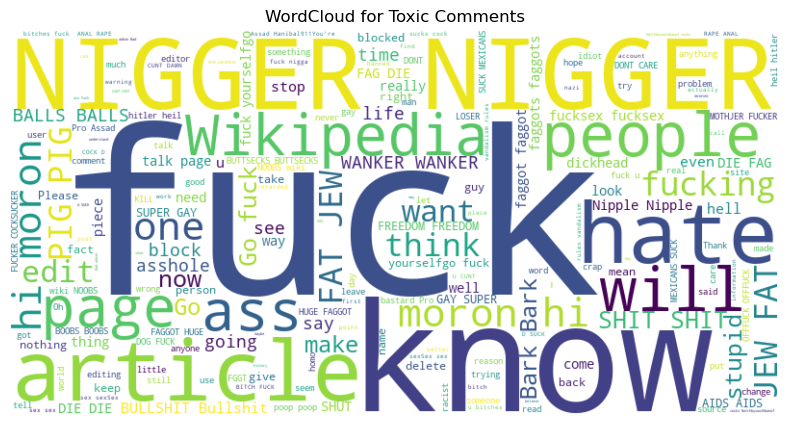

In [7]:
# WordCloud for Toxic Comments
toxic_comments = ' '.join(train[train['toxic'] == 1]['comment_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(toxic_comments)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud for Toxic Comments')
plt.show()


In [8]:
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Clean function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)  # Remove text in square brackets
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'<.*?>+', '', text)  # Remove HTML tags
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # Remove punctuation
    text = re.sub(r'\n', '', text)  # Remove newlines
    text = re.sub(r'\w*\d\w*', '', text)  # Remove words containing numbers
    return text

# Apply cleaning
train['clean_comment'] = train['comment_text'].apply(clean_text)
test['clean_comment'] = test['comment_text'].apply(clean_text)


In [9]:
train['count_star'] = train['clean_comment'].str.count('\*')
train['count_question'] = train['clean_comment'].str.count('\?')
train['count_exclamation'] = train['clean_comment'].str.count('!')
train['count_punctuation'] = train['clean_comment'].apply(lambda x: sum(x.count(p) for p in string.punctuation))


In [10]:
def punctuation_summary_with_percent(df, label_cols):
    """
    Returns a summary table of counts and percentages of *, ?, ! per category 
    and for non-toxic comments.
    """
    summary = []

    for cat in label_cols:
        sub = df[df[cat] == 1]
        total = len(sub)
        summary.append({
            'category': cat,
            'total_comments': total,
            'star_count': (sub['comment_text'].str.count('\*') > 0).sum(),
            'question_count': (sub['comment_text'].str.count('\?') > 0).sum(),
            'exclamation_count': (sub['comment_text'].str.count('!') > 0).sum()
        })

    # For non-toxic comments
    non_toxic = df[df['num_labels'] == 0]
    total = len(non_toxic)
    summary.append({
        'category': 'non_toxic',
        'total_comments': total,
        'star_count': (non_toxic['comment_text'].str.count('\*') > 0).sum(),
        'question_count': (non_toxic['comment_text'].str.count('\?') > 0).sum(),
        'exclamation_count': (non_toxic['comment_text'].str.count('!') > 0).sum()
    })

    # Create DataFrame
    summary_df = pd.DataFrame(summary)

    # Calculate percentages
    for punc in ['star', 'question', 'exclamation']:
        summary_df[f'{punc}_percent'] = (summary_df[f'{punc}_count'] / summary_df['total_comments'] * 100).round(2)

    return summary_df


# Usage
punct_summary = punctuation_summary_with_percent(train, label_cols)
print(punct_summary)


        category  total_comments  star_count  question_count  \
0          toxic           15294         365            3787   
1   severe_toxic            1595          36             234   
2        obscene            8449         210            1903   
3         threat             478           8              74   
4         insult            7877         164            1710   
5  identity_hate            1405          24             291   
6      non_toxic          143346        1463           36379   

   exclamation_count  star_percent  question_percent  exclamation_percent  
0               4068          2.39             24.76                26.60  
1                494          2.26             14.67                30.97  
2               2258          2.49             22.52                26.73  
3                151          1.67             15.48                31.59  
4               2142          2.08             21.71                27.19  
5                382          1

In [11]:
# Let's modify the features 
for p in ['count_star', 'count_question', 'count_exclamation']:
    train[p] = np.log1p(train[p])  # log(1 + x)

train['word_count'] = train['comment_text'].apply(lambda x: len(x.split()))
train['char_count'] = train['comment_text'].apply(len)
train['avg_word_len'] = train['char_count'] / train['word_count']


In [12]:
print(train.columns)


Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'num_labels', 'clean_comment', 'count_star',
       'count_question', 'count_exclamation', 'count_punctuation',
       'word_count', 'char_count', 'avg_word_len'],
      dtype='object')


In [13]:
# Label columns
label_cols = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
y = train[label_cols]


In [14]:
# Numeric features
num_features = train[['count_star','count_question','count_exclamation',
                      'word_count','char_count','avg_word_len']].values


In [15]:
# TF-IDF for feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import numpy as np
tfidf = TfidfVectorizer(max_features=50000, ngram_range=(1,2))
X_tfidf = tfidf.fit_transform(train['clean_comment'])


In [16]:
# Combine
X = hstack([X_tfidf, num_features])


In [17]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Her etiket için ayrı model eğit
models = {}
auc_scores = []
y_pred = []

for col in label_cols:
    print(f"Training for {col}...")
    model = LogisticRegression(max_iter=2000, n_jobs=-1)
    model.fit(X_train, y_train[col])
    models[col] = model
    
    # Predict probabilities for validation
    pred = model.predict_proba(X_valid)[:, 1]
    y_pred.append(pred)
    
    auc = roc_auc_score(y_valid[col], pred)
    auc_scores.append(auc)
    print(f"{col:15s} AUC: {auc:.4f}")

y_pred = np.array(y_pred).T
print("Mean AUC:", np.mean(auc_scores))


Training for toxic...
toxic           AUC: 0.9663
Training for severe_toxic...
severe_toxic    AUC: 0.9739
Training for obscene...
obscene         AUC: 0.9807
Training for threat...
threat          AUC: 0.9805
Training for insult...
insult          AUC: 0.9722
Training for identity_hate...
identity_hate   AUC: 0.9604
Mean AUC: 0.9723090093931996


In [19]:
# Test verisi için özellikler
test['count_star'] = test['clean_comment'].str.count('\*')
test['count_question'] = test['clean_comment'].str.count('\?')
test['count_exclamation'] = test['clean_comment'].str.count('!')
test['word_count'] = test['clean_comment'].apply(lambda x: len(x.split()))
test['char_count'] = test['clean_comment'].apply(len)
test['avg_word_len'] = test['char_count'] / test['word_count'].replace(0, np.nan)
test.fillna(0, inplace=True)


In [20]:
num_features = ['count_star', 'count_question', 'count_exclamation',
                'word_count', 'char_count', 'avg_word_len']

X_test_tfidf = tfidf.transform(test['clean_comment'])
X_test_num = test[num_features].values
X_test_final = hstack([X_test_tfidf, X_test_num])


In [21]:
# Test tahminleri
y_test_pred = []
for col in label_cols:
    pred = models[col].predict_proba(X_test_final)[:, 1]
    y_test_pred.append(pred)

y_test_pred = np.array(y_test_pred).T


In [22]:
import pandas as pd

# Create submission DataFrame
submission = pd.DataFrame(y_test_pred, columns=label_cols)
submission.insert(0, 'id', test['id'])

# Save to CSV
submission.to_csv('submission.csv', index=False)

print("✅ Submission file saved as submission.csv")
submission.head()


✅ Submission file saved as submission.csv


,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.992759,0.080803,0.979551,0.023814,0.906698,0.218637
1,0000247867823ef7,0.010229,0.001405,0.005353,0.000740,0.007025,0.003015
2,00013b17ad220c46,0.008052,0.001530,0.007433,0.001056,0.005760,0.001827
3,00017563c3f7919a,0.003003,0.001571,0.003555,0.001134,0.002960,0.001394
4,00017695ad8997eb,0.048896,0.004950,0.017425,0.001968,0.015067,0.004594


In [23]:
import joblib

# Modelleri ve TF-IDF vektörizeri kaydet
joblib.dump(models, 'toxic_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

print("✅ Modeller başarıyla kaydedildi.")


✅ Modeller başarıyla kaydedildi.


### Summary